In [1]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd
from astropy.constants import pc, c

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

Populating the interactive namespace from numpy and matplotlib


In [2]:
import spectools_ir
spectools_ir.__file__

'C:\\Users\\ksn70\\python\\lib\\site-packages\\spectools_ir\\__init__.py'

get hitran data

In [3]:
hitran_data=extract_hitran_data('CO',4.58,5.2,vup=1)  

Read in disk data and plot

In [4]:
infile='C:\\Users\\ksn70\\mypy\\rawdata\\nirspec_drtau.dat'

wave , flux = np.loadtxt(infile, unpack=True, skiprows=21)
print(wave,flux)

[4.6492472 4.6493402 4.6494331 ... 5.0999174 5.1000195 5.1001215] [1.3894759 1.5901209 1.7907699 ...       nan       nan       nan]


In [5]:
#calculate doppler shifted wavelength
v_dop_test=26.
dopwave=hitran_data['wave']*(1+v_dop_test*1000/c.value)

Text(0, 0.5, 'Flux [Jy]')

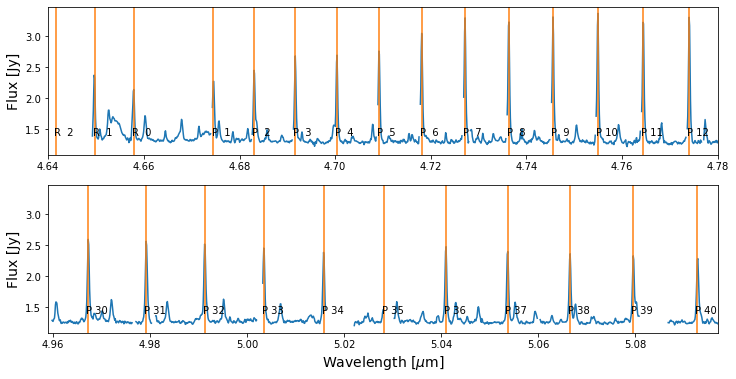

In [6]:
#Plot spectrum.
#The wavelength gap between the two plots is due to a section of poor atmosphere observations

fig=plt.figure(figsize=(12,6))

ax1=fig.add_subplot(211)
ax1.plot(wave,flux)
ax1.set_xlim(4.64,4.78) #first half of wavelength range 
for i,mywave in enumerate(dopwave):
    if( (mywave>4.64) & (mywave<4.78) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax1.set_ylabel('Flux [Jy]',fontsize=14)

ax2=fig.add_subplot(212)
ax2.plot(wave,flux)
ax2.set_xlim(4.959,5.097) #second half of wavelength range 
for i,mywave in enumerate(dopwave):
    if( (mywave>4.959) & (mywave<5.097) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)

Not enough data near  5.189196455005595  microns. Skipping.
Not enough data near  5.174972599607307  microns. Skipping.
Not enough data near  5.1609018222115965  microns. Skipping.
Not enough data near  5.146982692182924  microns. Skipping.
Not enough data near  5.133213778885752  microns. Skipping.
Not enough data near  5.119593651684542  microns. Skipping.
Not enough data near  5.1061213568222685  microns. Skipping.


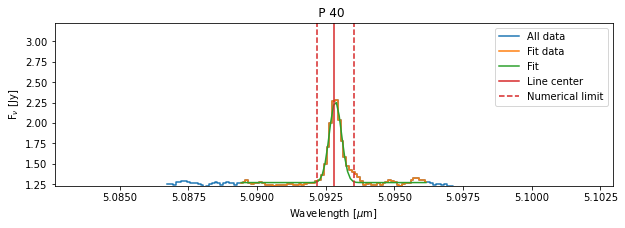

Is this fit okay? [y or n]y


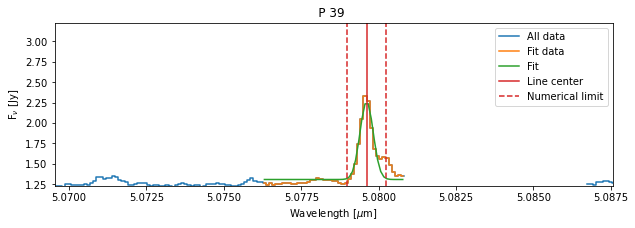

Is this fit okay? [y or n]y


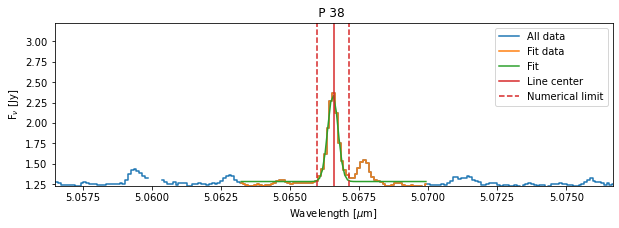

Is this fit okay? [y or n]y


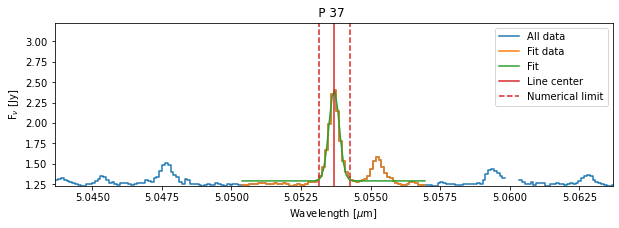

Is this fit okay? [y or n]y


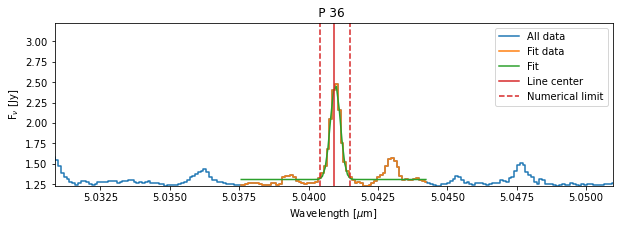

Is this fit okay? [y or n]y


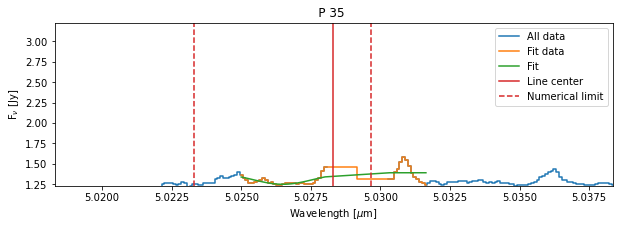

Is this fit okay? [y or n]n


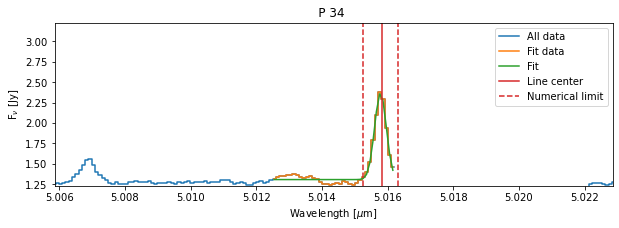

Is this fit okay? [y or n]y


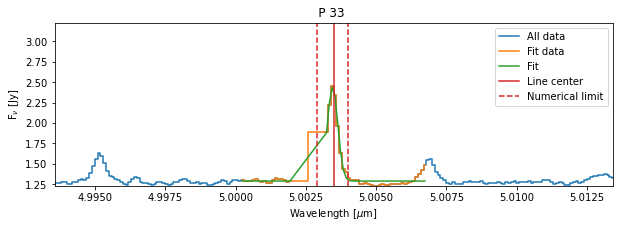

Is this fit okay? [y or n]n


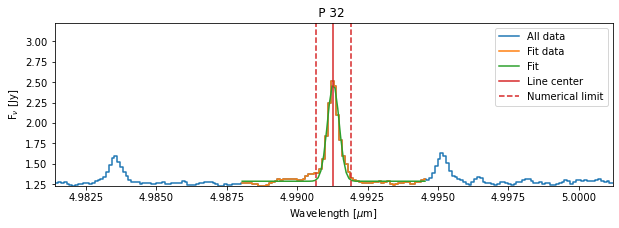

Is this fit okay? [y or n]y


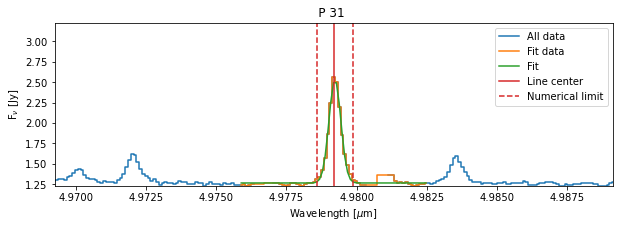

Is this fit okay? [y or n]y


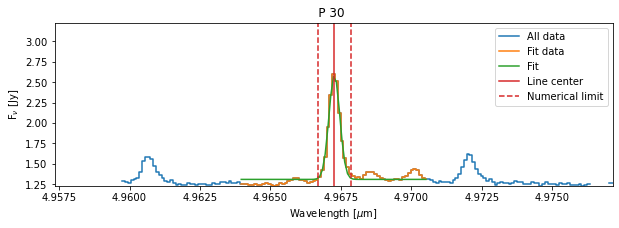

Is this fit okay? [y or n]y
Not enough data near  4.955465897090247  microns. Skipping.
Not enough data near  4.94379143422085  microns. Skipping.
Not enough data near  4.932247159185422  microns. Skipping.
Not enough data near  4.920832118226934  microns. Skipping.
Not enough data near  4.90954488070985  microns. Skipping.
Not enough data near  4.898384492877144  microns. Skipping.
Not enough data near  4.88735000097179  microns. Skipping.
Not enough data near  4.876439974358251  microns. Skipping.
Not enough data near  4.865653936158015  microns. Skipping.
Not enough data near  4.854990932614054  microns. Skipping.
Not enough data near  4.844449533090832  microns. Skipping.
Not enough data near  4.834029737588349  microns. Skipping.
Not enough data near  4.82372916171404  microns. Skipping.
Not enough data near  4.813548282346418  microns. Skipping.
Not enough data near  4.803485668849946  microns. Skipping.
Not enough data near  4.793539413710573  microns. Skipping.
Not enough data 

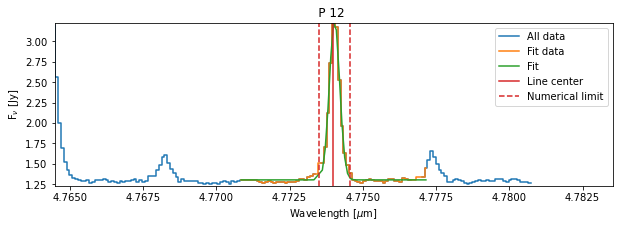

Is this fit okay? [y or n]y


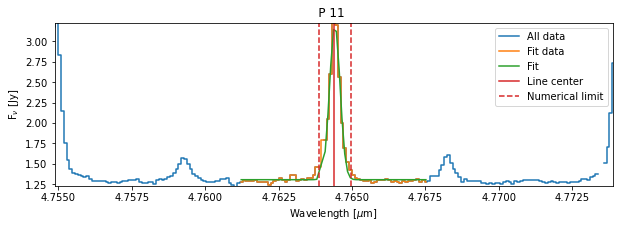

Is this fit okay? [y or n]y


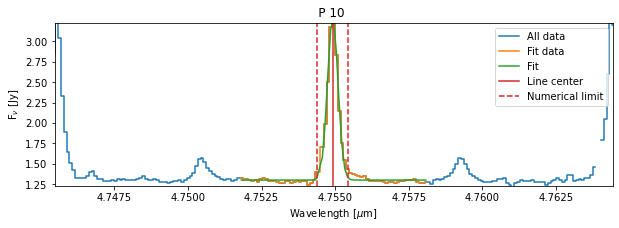

Is this fit okay? [y or n]y


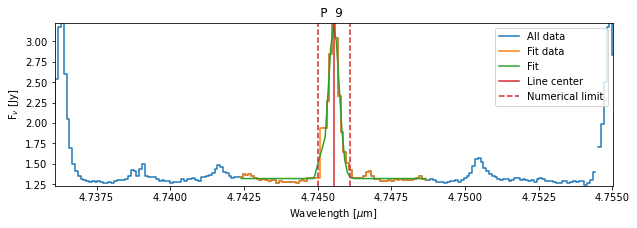

Is this fit okay? [y or n]y


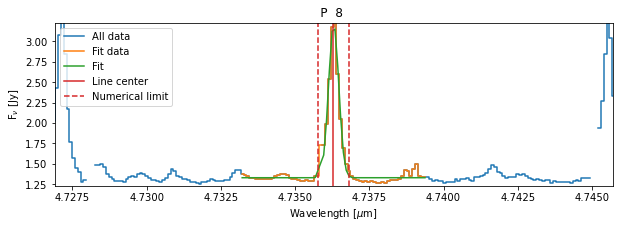

Is this fit okay? [y or n]y


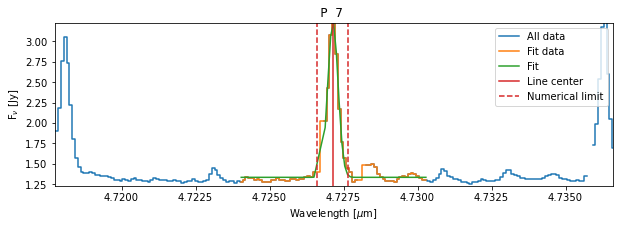

Is this fit okay? [y or n]y


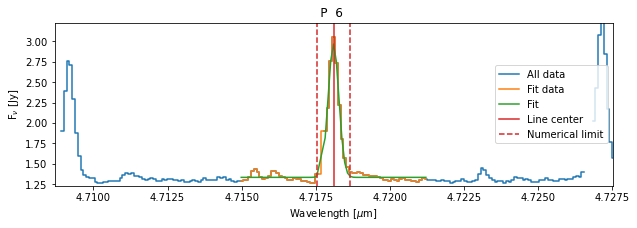

Is this fit okay? [y or n]y


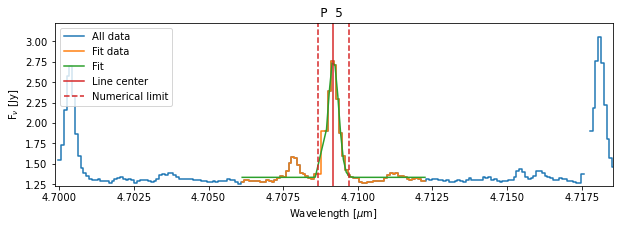

Is this fit okay? [y or n]y


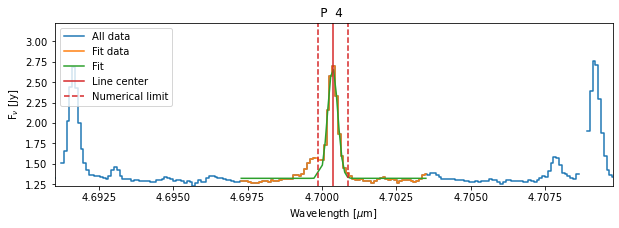

Is this fit okay? [y or n]y


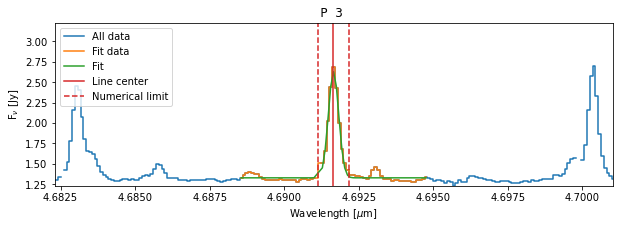

Is this fit okay? [y or n]y


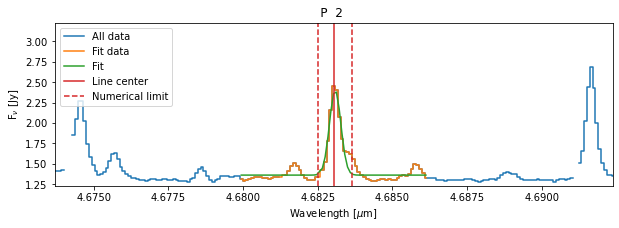

Is this fit okay? [y or n]y


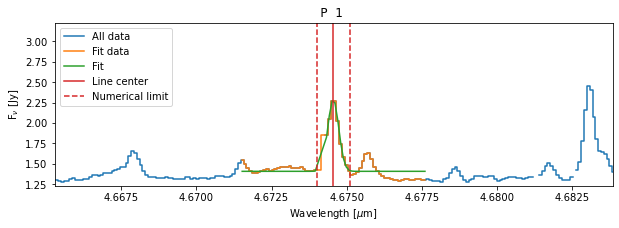

Is this fit okay? [y or n]n


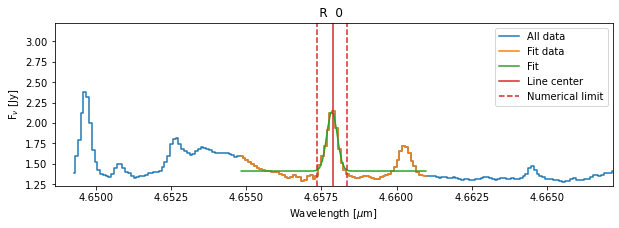

Is this fit okay? [y or n]n


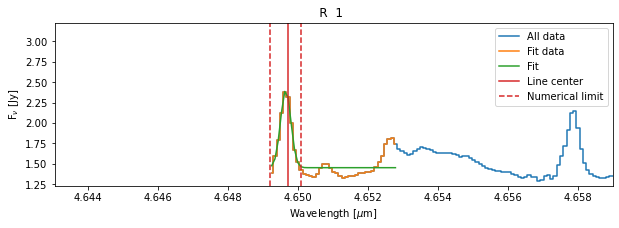

Is this fit okay? [y or n]n
Not enough data near  4.641644546724046  microns. Skipping.
Not enough data near  4.6336782911694  microns. Skipping.
Not enough data near  4.625815995130524  microns. Skipping.
Not enough data near  4.618056227971878  microns. Skipping.
Not enough data near  4.61039851281495  microns. Skipping.
Not enough data near  4.602842849659739  microns. Skipping.
Not enough data near  4.595388284749221  microns. Skipping.
Not enough data near  4.58803386432637  microns. Skipping.
Not enough data near  4.580779588391185  microns. Skipping.


In [5]:
#Calculate fluxes.
#lineflux_data=calc_fluxes(wave,flux,hitran_data, v_dop=26,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)
#pickle.dump(lineflux_data,open('lineflux_data.p','wb')) #save for convenience

lineflux_data=pickle.load(open('lineflux_data.p','rb'))  #restore lineflux_data if you don't want to re-run

In [7]:
lineflux_data

molec_id,local_iso_id,wn,a,elower,Vp_HITRAN,Vpp_HITRAN,Qp_HITRAN,Qpp_HITRAN,gup,glow,nu,eup_k,wave,lineflux,lineflux_Gaussian,lineflux_err,linewidth,linewidth_err,v_dop_fit,v_dop_fit_err,continuum,continuum_err
,,,,,,,,,,,,,,W / m2,,W / m2,km / s,km / s,km / s,km / s,Jy,Jy
int32,int32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
5,1,1963.7288,13.67,3136.5095,1,0,,P 40,79.0,81.0,58871110000000.0,7338.1045,5.092353,6.586782253100465e-17,6.383251498973935e-17,2.2557913184344847e-18,30.745154668490784,0.8340897188001538,29.291417056677894,0.34261417426610524,1.268036103788094,0.004862768756281566
5,1,1968.8247,13.78,2984.2708,1,0,,P 39,77.0,79.0,59023880000000.0,7126.399,5.079172,6.222435681318153e-17,5.96863022527438e-17,4.88307436176002e-18,29.81380025514896,1.9638815914203505,25.897973097815996,0.7924144514987804,1.3046658185738995,0.013871671331421058
5,1,1973.8915,13.89,2835.7627,1,0,,P 38,75.0,77.0,59175780000000.0,6920.019,5.0661345,5.985039043620385e-17,5.864405391142606e-17,3.7624402653745155e-18,26.293006184861085,1.3927351597630346,24.47250044418883,0.5749846055340427,1.2808208287962792,0.009295337094915031
5,1,1978.9287,13.99,2690.9912,1,0,,P 37,73.0,75.0,59326790000000.0,6718.9727,5.0532393,6.197028027992713e-17,6.123616504449078e-17,3.951245210911555e-18,26.104209998139577,1.3965994893390223,26.663551830802596,0.5765521764527932,1.288495704776626,0.009893012852360269
5,1,1983.9363,14.09,2549.962,1,0,,P 36,71.0,73.0,59476917000000.0,6523.2676,5.0404844,6.244828564555363e-17,6.180557825152134e-17,3.840487334750753e-18,25.111791546107252,1.3165687718140235,28.530736630654697,0.5444518571222877,1.3056540343185172,0.009846109891339695
5,1,1993.8622,14.31,2279.1511,1,0,,P 34,67.0,69.0,59774486000000.0,6147.9116,5.015392,5.687854979107608e-17,5.664149889335373e-17,2.2123624891564514e-18,25.14694318485306,0.8748766633686111,23.30544147843485,0.352227608159143,1.3048347481642275,0.008264501902705756
5,1,2003.668,14.52,2023.3715,1,0,,P 32,63.0,65.0,60068456000000.0,5794.0107,4.9908466,7.692365068343046e-17,7.49532901087346e-17,2.4834024755748427e-18,29.491968947666255,0.7650270101012938,26.13055808613405,0.3144608753031528,1.2838844910017733,0.005446476566376108
5,1,2008.5254,14.63,1901.1309,1,0,,P 31,61.0,63.0,60214080000000.0,5625.123,4.978777,8.248955427618747e-17,8.132465604342627e-17,2.1541485128617236e-18,30.097922918464274,0.6309083656052967,27.018822403321114,0.25632328350657535,1.2631616329430544,0.005464410434472499


Text(0, 0.5, 'Line flux [10$^{-16}$ W m$^{-2}$]')

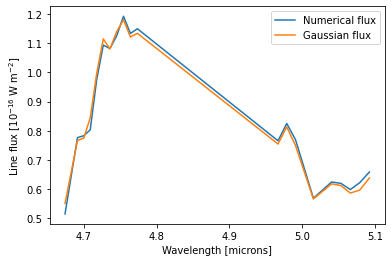

In [8]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux']*1e16, label='Numerical flux')
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux_Gaussian']*1e16 ,label='Gaussian flux')
ax1.legend()
ax1.set_xlabel('Wavelength [microns]')
ax1.set_ylabel(r'Line flux [10$^{-16}$ W m$^{-2}$]')

### Creating "composite lineshape" with info from flux_calculator output

In [9]:
lineshape_data=make_lineshape(wave,flux,lineflux_data)

Text(0, 0.5, 'Arbitrary flux')

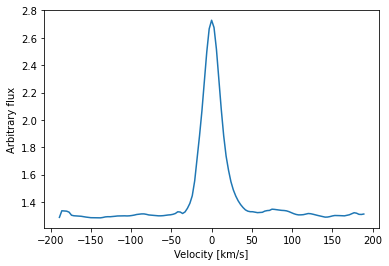

In [10]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineshape_data[0],lineshape_data[1])

ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')

### "Display resultant fluxes in a rotation diagram"

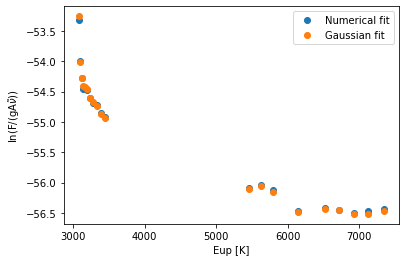

In [11]:
rot_numerical=make_rotation_diagram(lineflux_data,fluxkey='lineflux')
rot_Gaussian=make_rotation_diagram(lineflux_data,fluxkey='lineflux_Gaussian')

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rot_numerical['x'],rot_numerical['y'],'C0o',label='Numerical fit')
ax1.plot(rot_Gaussian['x'],rot_Gaussian['y'],'C1o', label='Gaussian fit')

ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.legend()

### Slabspec

In [40]:
logomega=-15.427 #omega=area/(d_pc*pc.value)**2.
omega=10**logomega
distance=140 #pc, Salyk et al. 2008
Area=omega*(distance*pc.value)**2
print(Area)

#Make slab model
#This can take a few seconds to run.  It is primarily limited by the convolution time.
model_output=make_spec('CO',5.1e21,1455.859,Area,wmin=4.58,wmax=5.2,convol_fwhm=30.,d_pc=140.,res=1e-5,vup=1)

6.981635348076992e+21


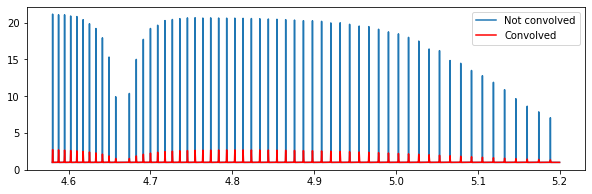

In [42]:
#Plot slab model
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(111)
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['flux']+1,label='Not convolved')
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['convolflux']+1,'r',label='Convolved')
ax1.legend()

### Output model as rotation diagram

In [35]:
rd_model=make_rotation_diagram(model_output['lineparams'])
rd_data=make_rotation_diagram(lineflux_data)

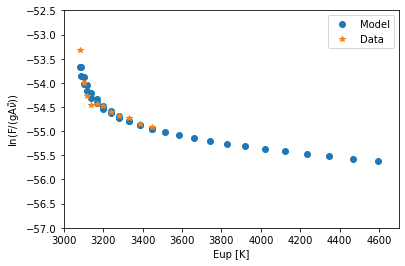

In [36]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rd_model['x'],rd_model['y'],' C0o',label='Model')
ax1.plot(rd_data['x'],rd_data['y'],' C1*',label='Data')
ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.set_xlim(3000,4700)
ax1.set_ylim(-57,-52.5)
ax1.legend()

### Slab_fitter

In [7]:
myconfig=Config('C:\\Users\\ksn70\\mypy\\configdr_tau_12.json')  #reads config.json by default, or can specify path to file as input parameter
myconfig.display()

data=lineflux_data

mydata=LineData(data)
myretrieval=Retrieval(myconfig,mydata)

{
 "tmin": 1000,
 "tmax": 1600,
 "lognmin": 21.2,
 "lognmax": 23,
 "logomegamin": -17,
 "logomegamax": -15.2,
 "Nwalkers": 20,
 "Nburnin": 1000,
 "Nsamples": 3000
}


NameError: name 'lineflux_data' is not defined

### Run Retrieval

In [45]:
mychain=myretrieval.run_emcee()  #Run retrieval.  May take a while, depending on number of samples
pickle.dump(mychain,open('test_chain.p','wb'))  #Save for convenience and later retrieval
os.system('afplay /System/Library/Sounds/Sosumi.aiff')

mychain=pickle.load(open('test_chain.p','rb'))  
postsamples=get_samples(mychain,myconfig.getpar('Nburnin'))  #Get list of samples, after removing burnin, from chain

Number of total samples: 60000
Run time [s]: 459.5301194190979


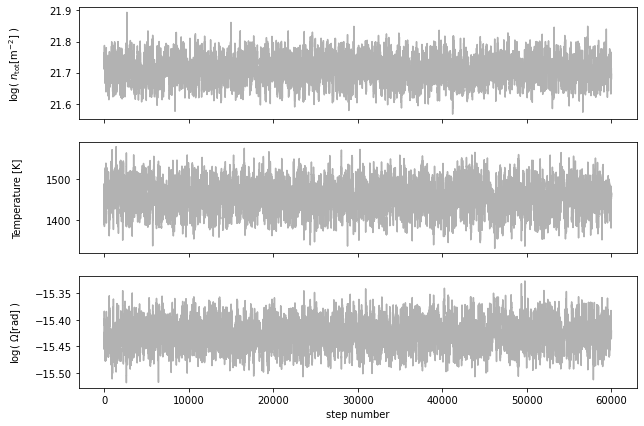

In [46]:
#Trace plot - examine samples
trace_plot(postsamples)

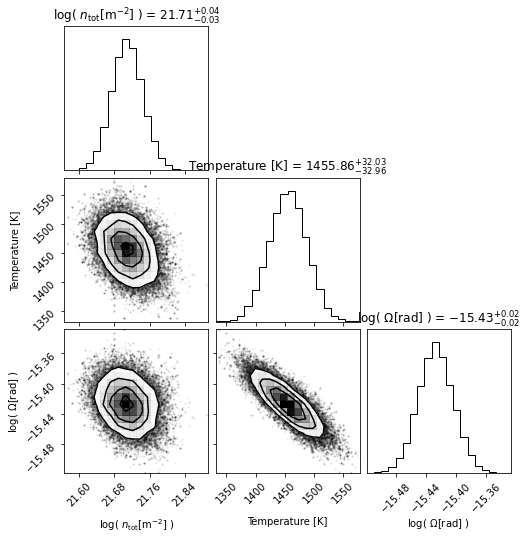

In [47]:
#Corner plot - see posterior distributions
fig=corner_plot(postsamples)

In [49]:
# Best fit parameters - best fit parameters plus/minus 1-sigma intervals
best_fit=find_best_fit(postsamples,show=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

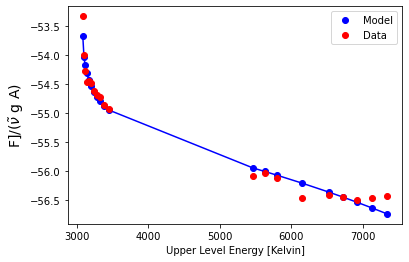

In [48]:
#Rotation diagram
modelflux=compute_model_fluxes(mydata,postsamples) #Compute model fluxes for ecah line in data
rotdiag=mydata.rot_diagram(modelfluxes=modelflux,units='mks') #Rotation diagram for data and model

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')

ax1.set_xlabel('Upper Level Energy [Kelvin]')
#ax1.set_ylabel(r'F[W m$^{-2}$]/($\~{\nu}$ [m$^{-1}$]g A[s$^{-1}$])',fontsize=14)
ax1.set_ylabel(r'F]/($\~{\nu}$ g A)',fontsize=14)
ax1.legend()